![CC-BY-SA](https://mirrors.creativecommons.org/presskit/buttons/88x31/svg/by-sa.svg)


This notebook was created by [Bernardo Freitas Paulo da Costa](http://www.im.ufrj.br/bernardofpc),
and is licensed under Creative Commons BY-SA.

Antes de enviar este Teste, verifique que tudo está funcionando como esperado.
Por exemplo, **rode o código inteiro, do zero**.
Para isso, vá no menu, escolha _Kernel_, depois _Restart & Run All_.

Verifique, também, que você respondeu todas as questões:
* as questões de código têm `YOUR CODE HERE` (e você pode apagar o `raise NotImplemented` ao incluir sua resposta)
* as questões discursivas têm "YOUR ANSWER HERE".

---

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# Regressão periódica

## Dados

Nesta primeira parte iremos ajustar uma curva aos dados de demanda elétrica fornecidos pelo ONS,
para o período entre os dias *16.04.2018 - 16.05.2018*.

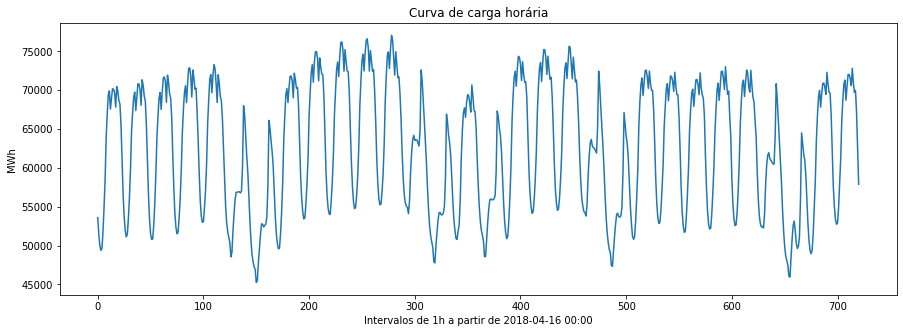

In [79]:
cch = np.load('Demanda_16.04.2018-16.05.2018.npz')
ys = cch['Demanda']
ts = np.arange(len(ys))

plt.figure(figsize=(15,5))
plt.plot(ts,ys)
plt.title("Curva de carga horária")
plt.ylabel("MWh")
plt.xlabel("Intervalos de 1h a partir de 2018-04-16 00:00");

Vamos pegar um intervalo com dias úteis.

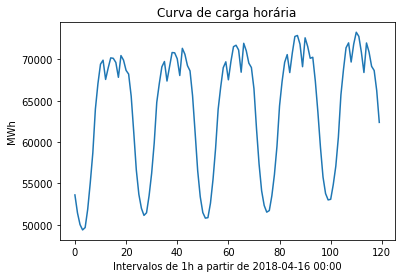

In [80]:
tmax = 120

plt.plot(ts[:tmax],ys[:tmax])
plt.title("Curva de carga horária")
plt.ylabel("MWh")
plt.xlabel("Intervalos de 1h a partir de 2018-04-16 00:00");

# Parte 1: Ajuste simples

## Questão 1: Matriz da regressão

O que salta aos olhos é o comportamento aproximadamente periódico,
logo uma primeira idéia é ajustar um modelo com funções também periódicas.

Um ajuste simples é o seguinte:
$$y(t) = c_0 + c_1\sin\left(\frac{2\pi t}{24}\right) + c_2\cos\left(\frac{2\pi t}{24}\right)$$

Explique porque o denominador 24 faz sentido para estes dados que temos.

Isto porque o consumo de energia possui um período aproximado de 24 horas. Logo é perceptível que o nosso modelo deve possuir uma periodização parecida, e isso é alcançado quando temos o denominador = 24.

Escreva a função `make_trig_matrix(ts,p)`, que monta a matriz de regressão $X$ tal que $Xc = y$ para o modelo proposto acima para `ts` e com período `p`.

**Observações:**
- A função constante está na base;
- A ordem das colunas importa para os asserts (mas não para o ajuste, se você sabe o que faz).
  Assim, as colunas devem vir na ordem das funções: constante, seno, cosseno.

In [81]:
def make_trig_matrix(ts,p):
    """ Retorna a matriz de regressão para o modelo y(t) = c0 + c1*sin(2*pi*t/p) + c2*cos(2*pi*t/p). """
    Matriz_resposta = [[1, np.sin(2*np.pi*t/p), np.cos(2*np.pi*t/p)] for t in ts]
    
    return np.array(Matriz_resposta)

In [82]:
tss = np.linspace(-2*np.pi,2*np.pi,51)
X = make_trig_matrix(tss,np.pi)

assert all([np.isclose(X[i][0],1) for i in range(10)])

In [83]:
# Testes de periodicidade

assert np.allclose(X[0][1],X[-1][1])
assert np.allclose(X[0][1],X[len(tss)//2][1])
assert np.allclose(X[0][2],X[-1][2])
assert np.allclose(X[0][2],X[len(tss)//2][2])

## Questão 2: Gráficos

Faça o gráfico tanto dos dados como do ajuste do modelo,
usando apenas as 120 primeiras observações, que correspondem aos primeiros cinco dias úteis.

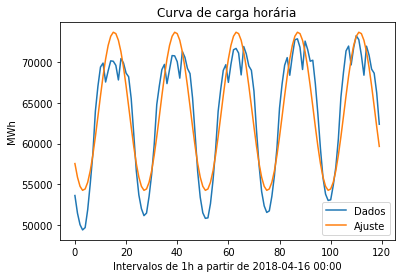

In [84]:
# YOUR CODE HERE
def model_par(ts, p, ys):
    M = make_trig_matrix(ts, p)
    MtM = np.matmul(M.T,M)
    return np.linalg.solve(MtM, np.dot(M.T,ys))

def model_fun(par):
    c0,c1, c2 = par
    def mf(t, p):
        return c0 + c1*(np.sin((2*np.pi*t)/p)) + c2*(np.cos((2*np.pi*t)/p))
    
    return mf

ts = ts[:tmax]
ys = ys[:tmax]
p = 24

plt.plot(ts, ys, label='Dados')
plt.title("Curva de carga horária")
plt.ylabel("MWh")
plt.xlabel("Intervalos de 1h a partir de 2018-04-16 00:00");

coef = model_par(ts, p, ys)
fmodelo = model_fun(coef)
plt.plot(ts, fmodelo(ts, p), label='Ajuste')
plt.legend()

ax = plt.gca()
plt.show()

In [85]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 2
assert len(ax.legend().texts) == 2

yss = [ax.lines[i].get_ydata() for i in range(2)]

assert 73000 <= np.max(yss) <= 73800
assert 49000 <= np.min(yss) <= 50000

In [86]:
ax = None

Plote também o residual (erro de ajuste)!

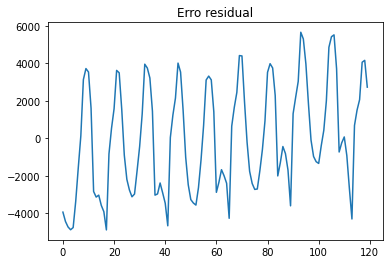

In [87]:
# YOUR CODE HERE
plt.plot(ts, ys - fmodelo(ts, p))
plt.title('Erro residual')

ax = plt.gca()
plt.show()

In [88]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 1


In [89]:
ax = None

Esse gráfico reflete alguma tendência nos dados que difere do ajuste?
Se sim qual função poderia ser acrescentada a base do modelo para tentar capturar essa tendência?

É possível perceber que a periodicidade do erro é diferente da periodicidade do ajuste.
Isto porque provavelmente há alguma periodicidade que não é ajustada pela nossa função.
E isso pode ser confirmado olhando no gráfico dos dados. Provavelmente isso pode ser melhorado adicionando mais funções periódicas no nosso modelo.

O que mais você percebe no gráfico de erros?

Possui um ajuste que não é de forma periódica, que parece assumir alguma forma parabólica. Que talvez poderia ser ajustado adicionando polinômios no nosso modelo.

## Questão 3: Uma base maior

Agora, vamos tentar um ajuste com mais funções periódicas (também ditas _harmônicas_):
$$y(t) = \alpha_0 +  \sum_{i=1}^k\alpha_i \sin\left(\frac{2\pi it}{24}\right) + \sum_{i=1}^k\beta_i \cos\left(\frac{2\pi it}{24}\right).$$

Para te auxiliar nessa tarefa escreva a função
- `make_full_trig_matrix(ts,p,k)`: Semelhante a `make_trig_matrix`, mas retorna a matriz para o ajuste acima,
  correspondente ao conjunto de harmônicos de $i=1$ até $i = k$.

In [90]:
def make_full_trig_matrix(ts, p, k):
    Matriz_resposta = []
    for t in ts:
        linha = [1]
        for i in range(1, k+1):
            linha.append(np.sin((2*np.pi*i*t)/p))
        
        for i in range(1, k+1):
            linha.append(np.cos((2*np.pi*i*t)/p))
        Matriz_resposta.append(linha)
        
    Matriz_resposta = np.array(Matriz_resposta)
    
    return Matriz_resposta

In [91]:
# Teste de sanidade
tss = np.arange(0,100)

X = make_full_trig_matrix(tss, 24, 1)
Y = make_trig_matrix(tss, 24)

for i in range(5):
    for j in range(3):
        assert np.isclose(X[i][j],Y[i][j])

In [92]:
# Teste de dimensão
tss = np.arange(0,100)

X = make_full_trig_matrix(tss, 24, 3)
assert np.shape(X) == (100,7)

## Questão 4: Gráficos de novo

Faça o gráfico do ajuste para $k = 2$, novamente para os 5 primeiros dias úteis.

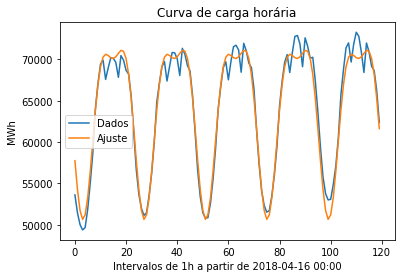

In [93]:
# YOUR CODE HERE
# YOUR CODE HERE
ts = ts[:tmax]
ys = ys[:tmax]
k = 2
p = 24

def model_par(ts, p, k, ys):
    M = make_full_trig_matrix(ts, p, k)
    MtM = np.matmul(M.T,M)
    return np.linalg.solve(MtM, np.dot(M.T,ys))

def model_fun(par):
    def mf(t, p, k):
        soma = par[0]
        
        for i in range(1, k+1):
            soma += par[i]*np.sin(2*np.pi*i*t/p)
            soma += par[i+k]*np.cos(2*np.pi*(i)*t/p)
        
        return soma
    
    return mf



plt.plot(ts, ys, label='Dados')
plt.title("Curva de carga horária")
plt.ylabel("MWh")
plt.xlabel("Intervalos de 1h a partir de 2018-04-16 00:00");

coef = model_par(ts, p, k, ys)
fmodelo = model_fun(coef)
plt.plot(ts, fmodelo(ts, p, k), label='Ajuste')
plt.legend()

ax = plt.gca()
plt.show()

In [94]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 2
assert len(ax.legend().texts) == 2

for i in range(2):
    yss = ax.lines[i].get_ydata()
    assert 71000 <= np.max(yss) <= 73300
    assert 49000 <= np.min(yss) <= 51300

In [95]:
ax = None

E não se esqueça do residual.

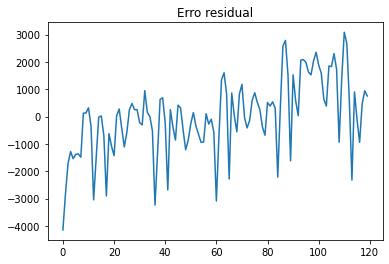

In [96]:
# YOUR CODE HERE
plt.plot(ts, ys - fmodelo(ts, p, k))
plt.title('Erro residual')

ax = plt.gca()
plt.show()

In [97]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 1


In [98]:
ax = None

Agora, faça o gráfico do erro para $k = 5$, $6$ e $10$, lado a lado.

**Dica:** Faça uma função `graph_err(k, tmax)` que faz o gráfico do erro do ajuste em função de `k` e `tmax`,
e use `subplot(1,3,j)` para selecionar o $j$-ésimo eixo.
(como é inspirada do MATLAB, essa função conta a partir de 1, não zero como padrão em python).

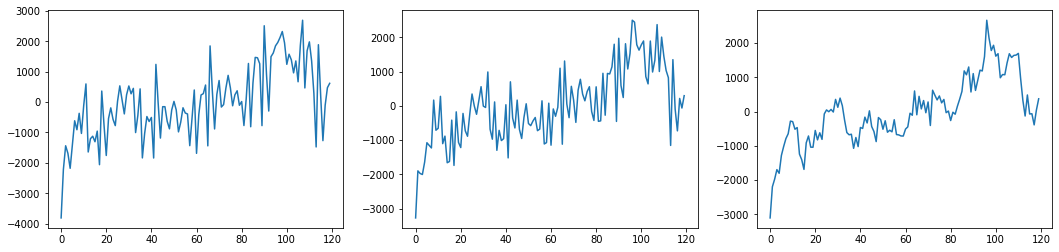

In [99]:
fig, axs = plt.subplots(ncols=3, figsize=(18,4))

# YOUR CODE HERE
def graph_err(ks):
    for ax, k in zip(axs, ks):
        coef = model_par(ts, p, k, ys)
        fmodelo = model_fun(coef)
        
        ax.plot(ts, ys - fmodelo(ts, p, k), label='Ajuste')
        
graph_err([5, 6, 10])
plt.show()

O que você muda e o que não muda ao aumentar $k$?

Existem certos pontos que não parecem melhorar com o aumento do k.
Claramente com o aumento do k as parte periódicas do gráfico, são aproximadas de forma melhor. Mas parece haver um limite, isto porque a nossa aproximação gera uma periodicidade igual para todas as montanhas(precisa ser feito o gráfico para comparação), entretanto por mais que os nossos dados apresentem uma periodicidade elas são apenas parecidas.

# Parte 2: Ajuste misto

## Questão 5: Polinômios e funções trigonométricas

Vamos adicionar polinômios à base, e comparar o erro de regressão obtido com uma base um pouco maior.

Comece implementando a função `make_poly_matrix(ts, d_max)`,
que retorna a matriz de ajuste polinomial de grau até $d_{max}$.

Para não duplicar a coluna de 1's na matriz do modelo completo,
a função `make_poly_matrix` não retorna a coluna correspondente às funções constantes,
mas apenas aos polinômios $X$, $X^2$, ..., $X^{d_{max}}$.

In [100]:
def make_poly_matrix(ts, dmax):
    assert dmax >= 1
    
    Matriz_resposta = []
    for t in ts:
        linha = []
        for i in range(1, dmax+1):
            valor = t**i
            linha.append(valor)
        Matriz_resposta.append(linha)
    
    Matriz_resposta = np.array(Matriz_resposta)
    return Matriz_resposta

In [101]:
tss = np.arange(1,5)

X = make_poly_matrix(tss,3)

assert np.allclose(X[0],[1,1,1])
assert np.allclose(X[1],[2,4,8])
assert np.allclose(X[2],[3,9,27])
assert np.allclose(X[3],[4,16,64])

Agora, faça uma função que retorna a matriz do ajuste misto

In [102]:
def make_trig_poly(ts, p, k, dmax):
    if dmax == 0:
        Matriz_resposta = make_full_trig_matrix(ts, p, k)
    
    else:
        Matriz_resposta = []
        for t in ts:
            linha = [1]
            for i in range(1, k+1):
                linha.append(np.sin((2*np.pi*i*t)/p))
            
            for i in range(1, k+1):
                linha.append(np.cos((2*np.pi*i*t)/p))
            
            for i in range(1, dmax+1):
                linha.append(t**i)
                
            Matriz_resposta.append(linha)
            
        Matriz_resposta = np.array(Matriz_resposta)
    
    return Matriz_resposta

def model_par(ts, ys, p, k, dmax):
    M = make_trig_poly(ts, p, k, dmax)
    MtM = np.matmul(M.T,M)
    return np.linalg.solve(MtM, np.dot(M.T,ys))

def model_fun(par):
    def mf(t, p, k, dmax):
        soma = par[0]
        
        for i in range(1, k+1):
            soma += par[i]*np.sin(2*np.pi*i*t/p)
            soma += par[i+k]*np.cos(2*np.pi*i*t/p)
        
        for i in range(1, dmax+1):
            soma += par[i+2*k]*t**i

        return soma
    
    return mf

## Questão 6: Mais gráficos ainda

Trace, num mesmo eixo, os erros correspondentes aos seguintes ajustes:
- Trigonométrico original, com apenas 1 harmônico
- Trigonométrico com 6 harmônicos
- Misto com 1 harmônico e um polinômio de grau 1
- Misto com 6 harmônicos e polinômio de grau 1
- Misto com 1 harmônico e polinômios de grau até 5
- Misto com 6 harmônicos e polinômios de grau até 5

In [103]:
def graph_err(ts, ys, p, k, dmax):
    coef = model_par(ts,ys, p, k, dmax)
    fmodelo = model_fun(coef)
        
    plt.plot(ts, ys - fmodelo(ts, p, k, dmax), label=f'har {k}, poly {dmax}')
    plt.title('Ajustes harmônicos e periódicos')
    plt.legend(loc='center left', bbox_to_anchor=(0.997, 0.83))

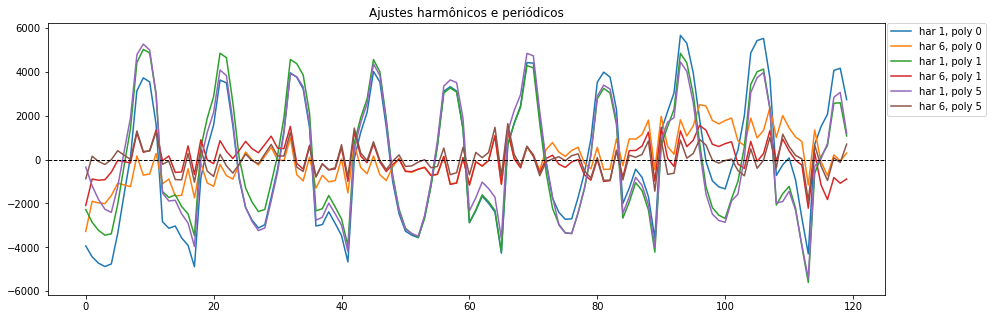

In [104]:
plt.figure(figsize=(15,5))

subts = ts[:120]
subys = ys[:120]

graph_err(subts, subys, 24, 1, 0)
graph_err(subts, subys, 24, 6, 0)
graph_err(subts, subys, 24, 1, 1)
graph_err(subts, subys, 24, 6, 1)
graph_err(subts, subys, 24, 1, 5)
graph_err(subts, subys, 24, 6, 5)

plt.axhline(color='black', linestyle='--', linewidth=1)
ax = plt.gca()
plt.show()

In [105]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 7
assert len(ax.legend().texts) == 6

O que você observou? Que melhora é obtida com o acréscimo dos polinômios da base?

Há uma melhora significativa nas partes onde os dados seguem um polinômio. E isso gera uma melhora nos pontos no geral. 
Mas é interessante perceber também que nos pontos de periodicidade , que são bem diferentes de um polinômio, há um aumento do erro.
Mas que é claramente compensado, pois o ajuste como um todo fica mais perto dos dados.

Faça agora dois gráficos de erro, para separar em dois grupos.

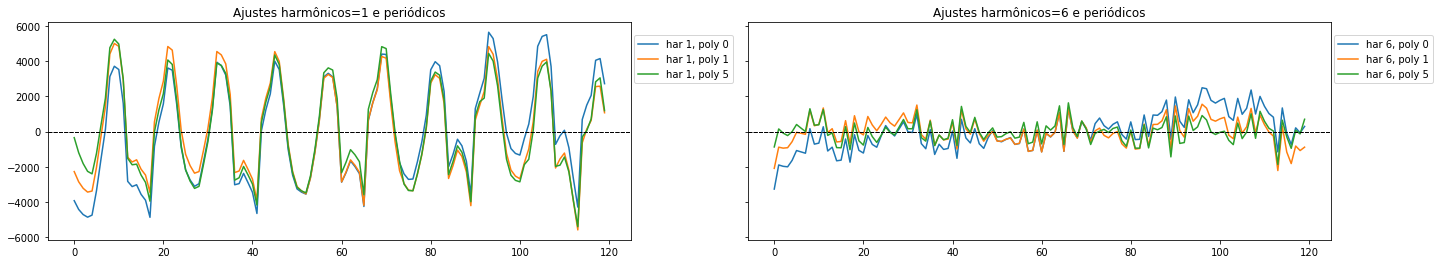

In [106]:
fig, axs = plt.subplots(ncols=2, figsize=(23,4), sharey=True)

subts = ts[:120]
subys = ys[:120]

# YOUR CODE HERE
def graph_err(ts, ys, p, k, dmax):
    coef = model_par(ts,ys, p, k, dmax)
    fmodelo = model_fun(coef)
    
    if k != 6:
        axs[0].plot(ts, ys - fmodelo(ts, p, k, dmax), label=f'har {k}, poly {dmax}')
        axs[0].set_title('Ajustes harmônicos=1 e periódicos')
        axs[0].legend(loc='center left', bbox_to_anchor=(0.997, 0.83))
        axs[0].axhline(color='black', linestyle='--', linewidth=1)
    
    else:
        axs[1].plot(ts, ys - fmodelo(ts, p, k, dmax), label=f'har {k}, poly {dmax}')
        axs[1].set_title('Ajustes harmônicos=6 e periódicos')
        axs[1].legend(loc='center left', bbox_to_anchor=(0.997, 0.83))
        axs[1].axhline(color='black', linestyle='--', linewidth=1)
graph_err(subts, subys, 24, 1, 0)
graph_err(subts, subys, 24, 6, 0)
graph_err(subts, subys, 24, 1, 1)
graph_err(subts, subys, 24, 6, 1)
graph_err(subts, subys, 24, 1, 5)
graph_err(subts, subys, 24, 6, 5)

ax = plt.gca()
plt.show()

- Quais são os grupos que você escolheu?
- Porquê?

Separei em poucos harmônicos = 1, e muitos harmônicos = 6.
Isto porque reparei, no gráfico de erro, que o maior erro se da quando as componentes harmônicas apresentam poucos termos (nesse caso = 1, 1cosseno e 1 seno). E quando possuem mais componentes harmônicas (nesse caso = 6, 6cossenos e 6senos), existe um ajuste consideravelmente melhor.